In [ ]:
import zipfile
import numpy as np
import pandas as pd
import os
import random
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, TensorBoard
from keras.backend import clear_session
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Input, Flatten, Activation, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.applications.resnet import ResNet50
from tensorflow.keras.applications import DenseNet121


Rozpakowanie pliku z obrazami i plikami .csv

In [ ]:
local_zip = '/content/drive/MyDrive/plant-pathology-2020-fgvc7.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

Odczyt danych

In [ ]:
img_path = "/content/images/"

submission_data = pd.read_csv("/content/sample_submission.csv")
test_data = pd.read_csv("/content/test.csv")
train_data = pd.read_csv("/content/train.csv")

train_dir = img_path + train_data['image_id'].values + '.jpg'
print("ilosc obrazow:", len(train_dir))
print(train_dir)
test_dir = img_path + test_data['image_id'].values + '.jpg'
print("ilosc obrazow:", len(train_dir))
print(test_dir)

ilosc obrazow: 1821
['/content/images/Train_0.jpg' '/content/images/Train_1.jpg'
 '/content/images/Train_2.jpg' ... '/content/images/Train_1818.jpg'
 '/content/images/Train_1819.jpg' '/content/images/Train_1820.jpg']
ilosc obrazow: 1821
['/content/images/Test_0.jpg' '/content/images/Test_1.jpg'
 '/content/images/Test_2.jpg' ... '/content/images/Test_1818.jpg'
 '/content/images/Test_1819.jpg' '/content/images/Test_1820.jpg']


Przygotowanie odpowiedniego formatu dla zestawu train i test 

In [ ]:
trainX = np.ndarray(shape=(len(train_dir), 300, 300, 3),dtype = np.float32)
i=0
for file in train_dir:
    image = cv2.resize(cv2.cvtColor(cv2.imread(file, 1), cv2.COLOR_BGR2RGB), (300, 300))
    trainX[i] = image
    i=i+1
trainX=trainX/255
print('Train size: {}'.format(trainX.shape))

Train size: (1821, 300, 300, 3)


In [ ]:
testX = np.ndarray(shape=(len(test_dir), 300, 300, 3),dtype = np.float32)
i=0
for file in test_dir:
    image = cv2.resize(cv2.cvtColor(cv2.imread(file, 1), cv2.COLOR_BGR2RGB), (300, 300))
    testX[i] = image
    i=i+1
testX=testX/255
print('Test size: {}'.format(testX.shape))

Test size: (1821, 300, 300, 3)


Przypisanie etykiety dla każdego obrazu

In [ ]:
labels = train_data.copy()
del labels['image_id']

trainY = np.array(labels.values)
print(trainY.shape,trainY[0])



(1821, 4) [0 0 0 1]


Podział zestawu na train i test. Podział 80% train, 20% test

In [ ]:
train_X, val_X, train_Y, val_Y = train_test_split(trainX, trainY, test_size=0.2)
print("TRAIN X:",train_X.shape)
print("TRAIN Y:",train_Y.shape)
print("VAL X:",val_X.shape)
print("VAL Y:",val_Y.shape)



TRAIN X: (1456, 300, 300, 3)
TRAIN Y: (1456, 4)
VAL X: (365, 300, 300, 3)
VAL Y: (365, 4)


In [ ]:
model = DenseNet121(include_top=False, weights="imagenet")

inputs = Input(shape=(300, 300, 3))
x = model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(4, activation="softmax", name="output")(x)
    
model = Model(inputs, output)
    
optimizer = Adam(learning_rate=0.002)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
#model.summary()

The following Variables were used a Lambda layer's call (tf.nn.convolution), but
are not present in its tracked objects:
  <tf.Variable 'conv1/conv/kernel:0' shape=(7, 7, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm), but
are not present in its tracked objects:
  <tf.Variable 'conv1/bn/gamma:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv1/bn/beta:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_1), but
are not present in its tracked objects:
  <tf.Variable 'co

In [ ]:
model_hist = model.fit(train_X, train_Y, batch_size = 32, epochs=10, validation_data=(val_X,val_Y))


Epoch 1/10
46/46 [==============================] - 76s 438ms/step - loss: 1.0454 - accuracy: 0.5473 - val_loss: 0.7455 - val_accuracy: 0.7425
Epoch 2/10
46/46 [==============================] - 10s 214ms/step - loss: 0.4909 - accuracy: 0.8307 - val_loss: 0.6299 - val_accuracy: 0.8110
Epoch 3/10
46/46 [==============================] - 10s 217ms/step - loss: 0.4235 - accuracy: 0.8609 - val_loss: 0.5504 - val_accuracy: 0.7973
Epoch 4/10
46/46 [==============================] - 10s 220ms/step - loss: 0.3116 - accuracy: 0.8916 - val_loss: 0.5506 - val_accuracy: 0.8110
Epoch 5/10
46/46 [==============================] - 10s 223ms/step - loss: 0.3190 - accuracy: 0.8994 - val_loss: 0.4623 - val_accuracy: 0.8411
Epoch 6/10
46/46 [==============================] - 10s 225ms/step - loss: 0.2827 - accuracy: 0.9082 - val_loss: 0.4388 - val_accuracy: 0.8329
Epoch 7/10
46/46 [==============================] - 10s 226ms/step - loss: 0.2023 - accuracy: 0.9348 - val_loss: 0.5142 - val_accuracy: 0.8411

Ewaluacja modelu

In [ ]:
results = model.evaluate(train_X, train_Y, batch_size=32)
print("train loss, train accuracy:", results)
results1 = model.evaluate(val_X, val_Y, batch_size=32)
print("val loss, val accuracy:", results1)
print("-------------------------------------------------------------")
print("Dokładność modelu na treningowym zbiorze wynosi: %.2f "% results[1])
print("Dokładność modelu na testowym zbiorze wynosi: %.2f"% results1[1])
print("-------------------------------------------------------------")

46/46 [==============================] - 8s 174ms/step - loss: 0.1442 - accuracy: 0.9533
train loss, train accuracy: [0.14419159293174744, 0.9532967209815979]
12/12 [==============================] - 2s 166ms/step - loss: 0.5120 - accuracy: 0.8164
val loss, val accuracy: [0.5119768977165222, 0.8164383769035339]
-------------------------------------------------------------
Dokładność modelu na treningowym zbiorze wynosi: 0.95 
Dokładność modelu na testowym zbiorze wynosi: 0.82
-------------------------------------------------------------


In [ ]:
def model_evaluate(train_loss, train_accuracy, val_loss, val_accuracy): 
    
    fig, axs = plt.subplots(2, 2)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    
    axs[0,0].set_xlabel('Numer epoki')
    axs[0,0].set_ylabel('Train Loss')
    axs[0,0].plot(train_loss)

    axs[0,1].set_xlabel('Numer epoki')
    axs[0,1].set_ylabel('Train Accuracy')
    axs[0,1].plot(train_accuracy)
    
    axs[1,0].set_xlabel('Numer epoki')
    axs[1,0].set_ylabel('Val loss')
    axs[1,0].plot(val_loss)

    axs[1,1].set_xlabel('Numer epoki')
    axs[1,1].set_ylabel('Val accuracy')
    axs[1,1].plot(val_accuracy) 
    plt.show()

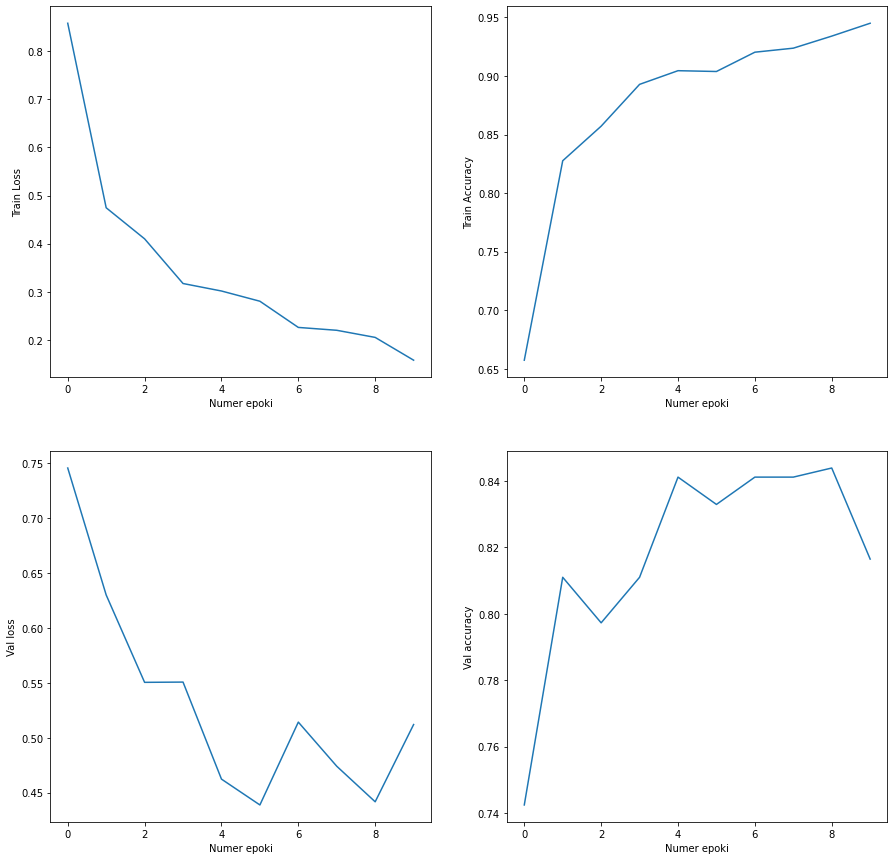

In [ ]:
train_loss = model_hist.history['loss'] 
train_acc = model_hist.history['accuracy'] 

val_loss = model_hist.history['val_loss']
val_accuracy = model_hist.history['val_accuracy']

model_evaluate(train_loss, train_acc, val_loss, val_accuracy) 



Predykcja

In [ ]:
predict = np.round(model.predict(testX),2)
submission = pd.DataFrame(predict)
submission.columns = ['healthy', 'multiple_diseases', 'rust', 'scab']
submission['image_id'] = submission_data['image_id']
submission = submission[['image_id','healthy', 'multiple_diseases', 'rust', 'scab']]
submission.to_csv('submission.csv',index=False)
submission
    

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.00,0.13,0.87,0.00
1,Test_1,0.00,0.00,1.00,0.00
2,Test_2,0.01,0.02,0.00,0.97
3,Test_3,1.00,0.00,0.00,0.00
4,Test_4,0.00,0.00,1.00,0.00
...,...,...,...,...,...
1816,Test_1816,0.00,0.11,0.89,0.00
1817,Test_1817,0.00,0.15,0.84,0.01
1818,Test_1818,0.00,0.00,1.00,0.00
1819,Test_1819,0.27,0.01,0.72,0.00


----------PREDYKCJA-----------
/content/images/Test_0.jpg
Categories: ['healthy', 'multiple_diseases', 'rust', 'scab']
Prediction: [0.   0.13 0.87 0.  ]


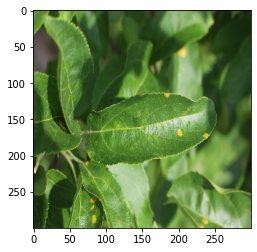

/content/images/Test_1.jpg
Categories: ['healthy', 'multiple_diseases', 'rust', 'scab']
Prediction: [0. 0. 1. 0.]


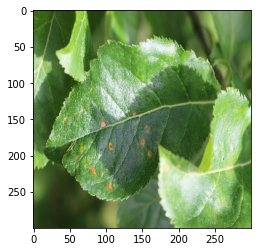

/content/images/Test_2.jpg
Categories: ['healthy', 'multiple_diseases', 'rust', 'scab']
Prediction: [0.01 0.02 0.   0.97]


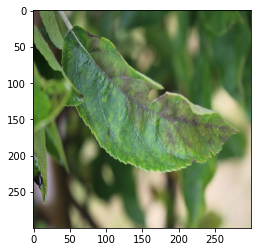

/content/images/Test_3.jpg
Categories: ['healthy', 'multiple_diseases', 'rust', 'scab']
Prediction: [1. 0. 0. 0.]


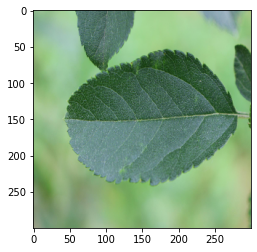

In [ ]:
categories = ['healthy', 'multiple_diseases', 'rust', 'scab']
print('----------PREDYKCJA-----------')
for i, img_path in enumerate(test_dir[0:4]):
    print(img_path)
    image_res = cv2.resize(cv2.cvtColor(cv2.imread(img_path, 1), cv2.COLOR_BGR2RGB), (300, 300))/255
    image_dim = np.expand_dims(image_res, axis = 0)
    prediction = np.round(model.predict(image_dim)[0],2)
    plt.imshow(image_res)
    print('Categories:', categories)
    print("Prediction:", prediction)
    #labels = [categories[i] for i, current_prediction in enumerate(prediction) if current_prediction == 1]
    plt.show()